In [18]:
import numpy as np
import os
from f1tenth_benchmarks.run_scripts.run_functions import *
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.utils.track_utils import CentreLine
from scipy import interpolate
import trajectory_planning_helpers as tph
from trajectory_planning_helpers.calc_head_curv_num import calc_head_curv_num
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')


def ensure_path_exists(path):
    if not os.path.exists(path): 
        os.mkdir(path)

save_path = 'Data/LocalMapRacing/'
ensure_path_exists(save_path)

# Image resolution convertor

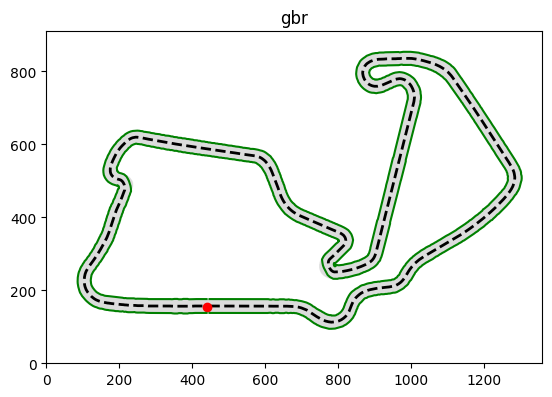

In [19]:
map_name = "gbr"
track = CentreLine(map_name)
mapdata = MapData(map_name)

map_img = plt.imread(f'maps/{map_name}.png')
# flip the image around x axis
map_img = np.flipud(map_img)

orig_x = mapdata.map_origin[0]
orig_y = mapdata.map_origin[1]
map_resolution = mapdata.map_resolution
l1 = track.path[:, :2] + track.nvecs * track.widths[:, 0][:, None]
l2 = track.path[:, :2] - track.nvecs * track.widths[:, 1][:, None]
startX = int((0-orig_x)/map_resolution)
startY = int((0-orig_y)/map_resolution)
scaled_x = (track.path[:, 0] - orig_x) / map_resolution
scaled_y = (track.path[:, 1] - orig_y) / map_resolution
# Scale the l1 and l2 boundaries using map resolution and origin
scaled_L1_x = (l1[:, 0] - orig_x) / map_resolution
scaled_L1_y = (l1[:, 1] - orig_y) / map_resolution
scaled_L2_x = (l2[:, 0] - orig_x) / map_resolution
scaled_L2_y = (l2[:, 1] - orig_y) / map_resolution

plt.figure( num=f'{map_name}_centreline')
plt.title(map_name)
# plt.imshow(map_img, cmap="gray", origin="lower")
mapdata.plot_map_img_light()
plt.plot(scaled_x, scaled_y, '--', linewidth=2, color='black') # Plotting the track centerline
plt.plot(startX, startY, 'ro') # Plotting the start point
plt.plot(scaled_L1_x, scaled_L1_y, color='green') # Plotting the track boundaries
plt.plot(scaled_L2_x, scaled_L2_y, color='green')

# Display the plot
plt.show()


Kappa: (1182,)
Path: (1182, 2)
Original Points: 1182
Smothed Points: 1182
Resampled Points: 1184


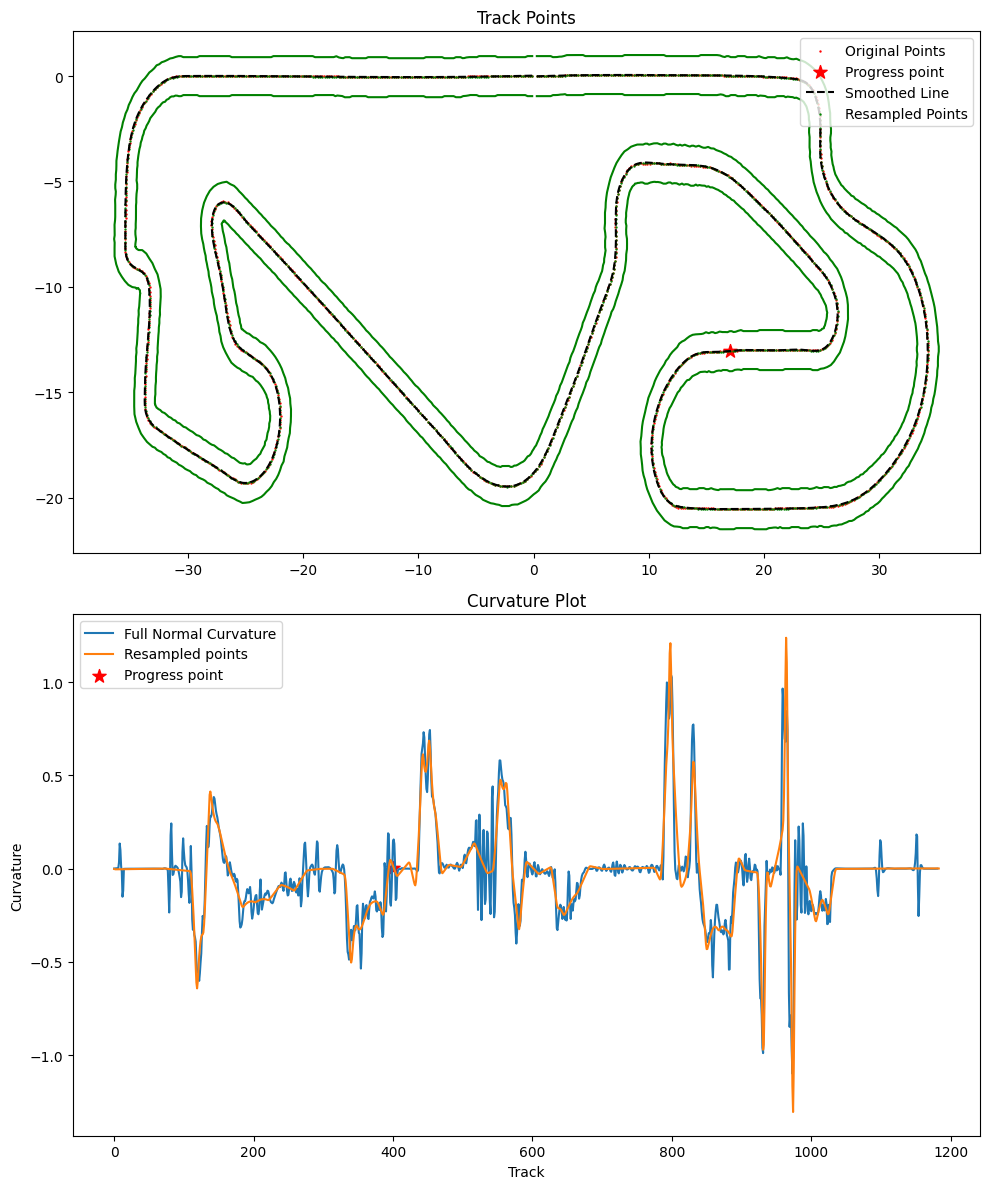

In [20]:
def interpolate_track_new(points, n_points=None, s=0):
    if len(points) <= 1:
        return points
    order_k = min(3, len(points) - 1)
    tck = interpolate.splprep([points[:, 0], points[:, 1]], k=order_k, s=s)[0]
    if n_points is None: n_points = len(points)
    track = np.array(interpolate.splev(np.linspace(0, 1, n_points), tck)).T
    return track

def resample_track_points(points, seperation_distance=0.2, smoothing=0.2):
    if points[0, 0] > points[-1, 0]:
        points = np.flip(points, axis=0)

    line_length = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))
    n_pts = max(int(line_length / seperation_distance), 2)
    smooth_line = interpolate_track_new(points, None, smoothing)
    resampled_points = interpolate_track_new(smooth_line, n_pts, 0)

    return resampled_points, smooth_line


map_name = "esp"
track = CentreLine(map_name)
kappa = track.kappa
path = track.path
print(f'Kappa: {kappa.shape}')
print(f'Path: {path.shape}')

Progress_point = 400

points = track.path

# Resample the points using the function
resampled_points, smooth_line = resample_track_points(points, seperation_distance=0.2, smoothing=0.5)
print(f'Original Points: {len(points)}')
print(f'Smothed Points: {len(smooth_line)}')
print(f'Resampled Points: {len(resampled_points)}')

fig, axs = plt.subplots(2, 1, figsize=(10, 12)) 
axs[0].scatter(points[:, 0], points[:, 1], color='red', label='Original Points', s =0.5)
axs[0].scatter(points[Progress_point, 0], points[Progress_point, 1], color='red', label='Progress point', marker='*', s=100)
axs[0].plot(smooth_line[:, 0], smooth_line[:, 1], '--', color='black', label='Smoothed Line')
axs[0].scatter(resampled_points[:, 0], resampled_points[:, 1], color='green', label='Resampled Points', s =0.5)
l1 = track.path[:, :2] + track.nvecs * track.widths[:, 0][:, None]
l2 = track.path[:, :2] - track.nvecs * track.widths[:, 1][:, None]
axs[0].plot(l1[:, 0], l1[:, 1], color='green')
axs[0].plot(l2[:, 0], l2[:, 1], color='green')
axs[0].set_title("Track Points")
axs[0].legend()

el_lengthsSmooth = np.sqrt(np.sum(np.diff(smooth_line, axis=0)**2, axis=1))
psiSmooth, kappaSmooth = calc_head_curv_num(
        path=smooth_line,
        el_lengths=el_lengthsSmooth,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

el_lengthsSmooth2 = np.sqrt(np.sum(np.diff(resampled_points, axis=0)**2, axis=1))
psiSmooth2, kappaSmooth2 = calc_head_curv_num(
        path=resampled_points,
        el_lengths=el_lengthsSmooth2,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

axs[1].plot(kappa, label='Full Normal Curvature')
Smoothkappa = np.flip(-kappaSmooth)
axs[1].plot(np.flip(-kappaSmooth2), label='Resampled points')
axs[1].scatter(Progress_point, Smoothkappa[Progress_point], color='red', label='Progress point', marker='*', s=100)
axs[1].set_title("Curvature Plot")
axs[1].legend()
axs[1].set_xlabel("Track")
axs[1].set_ylabel("Curvature")
plt.tight_layout()
plt.show()





Kappa: (474,)
Path: (474, 2)
Original Points: 474
Smothed Points: 474
Resampled Points: 474
Alt psi: 954


<function matplotlib.pyplot.show(close=None, block=None)>

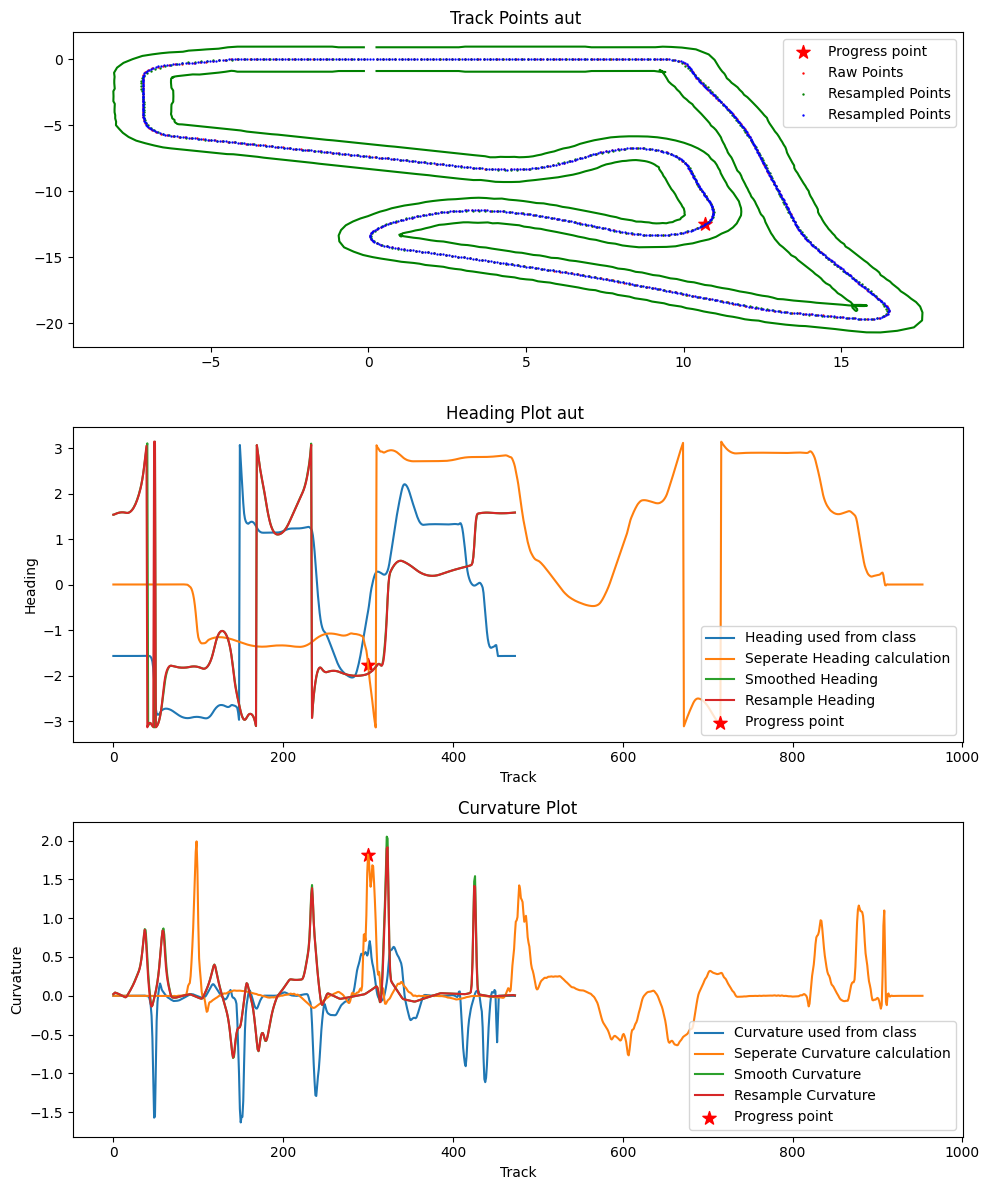

In [37]:
def interpolate_track_new(points, n_points=None, s=0):
    if len(points) <= 1:
        return points
    order_k = min(3, len(points) - 1)
    tck = interpolate.splprep([points[:, 0], points[:, 1]], k=order_k, s=s)[0]
    if n_points is None: n_points = len(points)
    track = np.array(interpolate.splev(np.linspace(0, 1, n_points), tck)).T
    return track

def resample_track_points(points, seperation_distance=0.2, smoothing=0.2):
    if points[0, 0] > points[-1, 0]:
        points = np.flip(points, axis=0)

    line_length = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))
    n_pts = max(int(line_length / seperation_distance), 2)
    smooth_line = interpolate_track_new(points, None, smoothing)
    resampled_points = interpolate_track_new(smooth_line, n_pts, 0)

    return resampled_points, smooth_line

map_name = "aut"
track = CentreLine(map_name)
kappa = track.kappa
path = track.path
psi = track.psi
print(f'Kappa: {kappa.shape}')
print(f'Path: {path.shape}')
Progress_point = 300

points = track.path

# Resample the points using the function
resampled_points, smooth_line = resample_track_points(points, seperation_distance=0.2, smoothing=0.5)
print(f'Original Points: {len(points)}')
print(f'Smothed Points: {len(smooth_line)}')
print(f'Resampled Points: {len(resampled_points)}')

path = track.path[:, :2]
closed_path = np.row_stack([path, path[0]])
closed_lengths =  np.linalg.norm(np.diff(closed_path, axis=0), axis=1)
coeffs_x, coeffs_y, A, normvec_normalized = tph.calc_splines.calc_splines(closed_path, closed_lengths)
path_interp, spline_inds, t_values, dists_interp = tph.interp_splines.interp_splines(coeffs_x, coeffs_y, closed_lengths, False, 0.1)

# path = path_interp

el_lengths = np.linalg.norm(np.diff(path_interp, axis=0), axis=1)
s_path = np.insert(np.cumsum(el_lengths), 0, 0)
alt_psi, alt_kappa = tph.calc_head_curv_num.calc_head_curv_num(np.column_stack((path_interp[:,1],path_interp[:,0])), el_lengths, False)
alt_psi = -alt_psi # Not supposed to be flipped
print(f'Alt psi: {len(alt_psi)}')


fig, axs = plt.subplots(3, 1, figsize=(10, 12)) 
# axs[0].scatter(points[:, 0], points[:, 1], color='red', label='Original Points', s =0.5)
axs[0].scatter(path[Progress_point, 0], path[Progress_point, 1], color='red', label='Progress point', marker='*', s=100)
# axs[0].plot(smooth_line[:, 0], smooth_line[:, 1], color='blue', label='Smoothed Line')
axs[0].scatter(path[:, 0], path[:, 1], color='red', label='Raw Points', s =0.5)
axs[0].scatter(resampled_points[:, 0], resampled_points[:, 1], color='green', label='Resampled Points', s =0.5)
axs[0].scatter(path_interp[:, 0], path_interp[:, 1], color='blue', label='Resampled Points', s =0.5)
# for i in range(len(path)):
#     axs[0].arrow(
#         path[i, 0],  # x-coordinate
#         path[i, 1],  # y-coordinate
#         0.5 * np.cos(alt_psi[i]),  # dx, based on heading angle
#         0.5 * np.sin(alt_psi[i]),  # dy, based on heading angle
       
        
#         color='blue',
#         head_width=0.05,  # Optional: adjust arrow head width
#         length_includes_head=True,  # Optional: include head in length
#     )
l1 = track.path[:, :2] + track.nvecs * track.widths[:, 0][:, None]
l2 = track.path[:, :2] - track.nvecs * track.widths[:, 1][:, None]
axs[0].plot(l1[:, 0], l1[:, 1], color='green')
axs[0].plot(l2[:, 0], l2[:, 1], color='green')
axs[0].set_title(f"Track Points {map_name} ")
axs[0].legend()

el_lengthsSmooth = np.sqrt(np.sum(np.diff(smooth_line, axis=0)**2, axis=1))
psiSmooth, kappaSmooth = calc_head_curv_num(
        path=smooth_line,
        el_lengths=el_lengthsSmooth,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

el_lengthsSmooth2 = np.sqrt(np.sum(np.diff(resampled_points, axis=0)**2, axis=1))
psi_Resample, kappa_Resample = calc_head_curv_num(
        path=resampled_points,
        el_lengths=el_lengthsSmooth2,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )



# axs[1].plot(psi, label='Full Normal Heading')
axs[1].plot(psi, label='Heading used from class') #This should not be flipped
axs[1].plot(alt_psi, label='Seperate Heading calculation')
axs[1].plot(psiSmooth, label='Smoothed Heading') 
axs[1].plot(psi_Resample, label='Resample Heading') 
axs[1].scatter(Progress_point, alt_psi[Progress_point], color='red', label='Progress point', marker='*', s=100)
axs[1].set_title(f"Heading Plot {map_name} ")
axs[1].legend()
axs[1].set_xlabel("Track")
axs[1].set_ylabel("Heading")

axs[2].plot(kappa, label='Curvature used from class') #This should not be flipped
axs[2].plot(alt_kappa, label='Seperate Curvature calculation') 
axs[2].plot(kappaSmooth, label='Smooth Curvature') 
axs[2].plot(kappa_Resample, label='Resample Curvature')
axs[2].scatter(Progress_point, alt_kappa[Progress_point], color='red', label='Progress point', marker='*', s=100)
axs[2].set_title("Curvature Plot")
axs[2].legend()
axs[2].set_xlabel("Track")
axs[2].set_ylabel("Curvature")
plt.tight_layout()
plt.show
